In [2]:
import keras

m = keras.models.load_model('cifar/models/shadow_models/0.1/train/0.keras')

2024-04-07 19:35:25.455993: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 19:35:25.467667: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 19:35:31.406728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 32, 32, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 16, 16, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 8, 8, 64)       │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_3           │ (None, 512)            │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,679,552 (6.41 MB)

 Trainable params: 559,850 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,119,702 (4.27 MB)

In [3]:
def do_read_single_model_params(m):
    layer_indices_for_adv = [
        1, #conv2d
        4, #conv2d_1
        7, #conv2d_2
        11, #dense
        13 #dense_1
    ]
    return [m.layers[i].weights for i in layer_indices_for_adv]

adv_inputs = do_read_single_model_params(m)

In [4]:
import re

def transform_input_name(name, index):
    # name cannot contain /
    result = name.replace("/", "-")
    # use standardized index number - add 0 if it does not exist
    result = re.sub("(_([0-9])+)?-", f"_{index}-", result)
    return result

In [5]:
def read_single_model_params(path):
    model = keras.models.load_model(path)
    return do_read_single_model_params(model)

In [371]:
#import multiprocessing as mp
from joblib import Parallel, delayed

def read_mult_model_params_mp(paths):
    # JOBLIB
    #parallel_results_generator = Parallel(n_jobs=5)(
    #    delayed(read_single_model_params)(p) for path in paths)
    #wb = list(parallel_results_generator)
    
    # MP
    #pool = mp.Pool(nr_cpu)
    #w_b = pool.map(read_single_model_params, paths)
    #pool.close()
    
    # SEQUENTIALLY:
    w_b = [read_single_model_params(p) for p in paths]
    
    return w_b

In [464]:
def load_model_params(my_models_per_y, ys, base_path, train_or_test):
    paths = [f"{base_path}/{j}/{train_or_test}/{i}.keras" for j in ys for i in range(my_models_per_y)]
    return read_mult_model_params_mp(paths)

In [457]:
all_y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_path = "cifar/models/shadow_models"

In [465]:
wb = load_model_params(200, all_y, base_path, 'train')

In [375]:
wb_test = load_model_params(50, all_y, base_path, 'test')

In [365]:
debug_paths = [f"y: {j}, model_i: {i}" for j in [0.1, 0.2] for i in range(5)]
for p in debug_paths:
    print(p)

y: 0.1, model_i: 0
y: 0.1, model_i: 1
y: 0.1, model_i: 2
y: 0.1, model_i: 3
y: 0.1, model_i: 4
y: 0.2, model_i: 0
y: 0.2, model_i: 1
y: 0.2, model_i: 2
y: 0.2, model_i: 3
y: 0.2, model_i: 4


In [467]:
import numpy as np

y = np.repeat(all_y, 200)

In [333]:
y_test = np.repeat(all_y, models_per_y_test)

In [10]:
import tensorflow as tf

def get_dataset(wb, y):
    def my_generator():
        for w, my_y in zip(wb, y):
            yield {transform_input_name(single_weight.path, i): single_weight for row, i in zip(w, range(len(w))) for single_weight in row}, [my_y]
    
    out_types = {transform_input_name(single_weight.path, i): tf.float32 for w, i in zip(wb[1], range(len(wb[1]))) for single_weight in w}
    out_shapes = {transform_input_name(single_weight.path, i): single_weight.shape for w, i in zip(wb[1], range(len(wb[1]))) for single_weight in w}
    return tf.data.Dataset.from_generator(my_generator, output_types=(out_types, tf.float32), output_shapes=(out_shapes, (1)))

In [468]:
ds = get_dataset(wb, y)

In [377]:
ds_test = get_dataset(wb_test, y_test)

conv_1 weights: KerasVariable shape=(3, 3, 3, 32)
3x3 filter für 3 channels, 32 stück
Die Reihenfolge *innerhalb* der filter ist wichtig, aber die Reihenfolge der filter selbst ist nicht relevant.

In [388]:
@keras.saving.register_keras_serializable()
class ConvSplitter(keras.layers.Layer):
    def __init__(self, neurons, **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
    
    #overwrite get_config for being able to save and load model
    def get_config(self):
        config = {
            "neurons" : self.neurons
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        return [inputs[:, :, :, :, i] for i in range(self.neurons)]

    
@keras.saving.register_keras_serializable()
class WeightsSplitter(keras.layers.Layer):
    def __init__(self, neurons, **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
    
    #overwrite get_config for being able to save and load model
    def get_config(self):
        config = {
            "neurons" : self.neurons
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        return [inputs[:, :, i] for i in range(self.neurons)]

    
@keras.saving.register_keras_serializable()   
class BiasSplitter(keras.layers.Layer):
    def __init__(self, neurons, **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
        
    #overwrite get_config for being able to save and load model
    def get_config(self):
        config = {
            "neurons" : self.neurons
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        return [inputs[:, i] for i in range(self.neurons)]


In [439]:
from keras import layers

def get_wb_meta_clf(adv_inputs):
    inputs = []
    kernel_splitters = []
    bias_splitters = []
    
    phi_layers = []
    for i in range(len(adv_inputs)):
        for my_input in adv_inputs[i]:
            keras_input = keras.Input(shape=my_input.shape, name=transform_input_name(my_input.path, i))
            inputs.append(keras_input)
            if my_input.path.find("conv") >= 0 and my_input.path.find("kernel") >= 0:
                kernel_splitters.append(ConvSplitter(my_input.shape[3])(keras_input))
            elif my_input.path.find("bias") >= 0:
                bias_splitters.append(BiasSplitter(my_input.shape[0])(keras_input))
            else:
                kernel_splitters.append(WeightsSplitter(my_input.shape[1])(keras_input))
                
    phi_layers = []
    for kernels, biases in zip(kernel_splitters, bias_splitters):
        channel_outputs = []
        for w, b in zip(kernels, biases):
            flatten_w = layers.Flatten()(w)
            reshaped_b = layers.Reshape((1,))(b)
            concat = layers.concatenate([flatten_w, reshaped_b])
            phi = layers.Dense(20, activation="relu")(concat)
            channel_outputs.append(phi)
        my_phi = layers.Add()(channel_outputs)
        phi_layers.append(my_phi)
    
    x = layers.BatchNormalization()(layers.concatenate(phi_layers))
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(30, activation='relu')(x)
    
    #x = layers.Dropout(0.2)(x)
    output = layers.Dense(1)(x)
    
    return keras.Model(inputs=inputs, outputs=output)

In [440]:
meta_clf = get_wb_meta_clf(adv_inputs)

In [441]:
meta_clf.save("cifar-wb-meta.keras")

In [470]:
meta_clf = keras.models.load_model("cifar-wb-meta.keras")

In [471]:
meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [394]:
ds_test.save("cifar/data/white-box/test-data")

In [395]:
ds.save("cifar/data/white-box/train-data")

In [396]:
ds_test_batched = ds_test.batch(8)

In [469]:
ds_train = ds.shuffle(1800).batch(30, drop_remainder=True)

In [461]:
len(wb)

450

In [454]:
np_ds = list(ds.as_numpy_iterator())

2024-04-09 14:11:40.320922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [455]:
len(np_ds)

450

In [ ]:
history = meta_clf.fit(ds_train, epochs=50, validation_data=ds_test_batched, callbacks=[keras.callbacks.EarlyStopping('val_r2_score', patience=5)])

Epoch 1/50


2024-04-09 14:38:02.167391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 936 of 1200
2024-04-09 14:38:04.922661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


     60/Unknown 138s 167ms/step - loss: 0.7838 - r2_score: -17.7842

2024-04-09 14:38:15.005789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:38:53.624946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 181s 885ms/step - loss: 0.7819 - r2_score: -17.6605 - val_loss: 1.7691 - val_r2_score: -54.9402
Epoch 2/50


2024-04-09 14:39:07.406546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1064 of 1200
2024-04-09 14:39:09.259452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.4548 - r2_score: -5.6874

2024-04-09 14:39:20.607160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:39:25.282879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 275ms/step - loss: 0.4540 - r2_score: -5.6475 - val_loss: 0.5890 - val_r2_score: -7.0634
Epoch 3/50


2024-04-09 14:39:35.975075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1020 of 1200
2024-04-09 14:39:38.201981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.3357 - r2_score: -2.5464

2024-04-09 14:39:47.275070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:39:53.692790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 273ms/step - loss: 0.3355 - r2_score: -2.5304 - val_loss: 0.4107 - val_r2_score: -2.6558
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.2742 - r2_score: -1.5458

2024-04-09 14:40:15.307738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:40:20.237188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - loss: 0.2740 - r2_score: -1.5324 - val_loss: 0.3444 - val_r2_score: -1.5998
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.2292 - r2_score: -0.6989

2024-04-09 14:40:42.677548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:40:46.739745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - loss: 0.2291 - r2_score: -0.6926 - val_loss: 0.2827 - val_r2_score: -0.8242
Epoch 6/50


2024-04-09 14:40:57.751681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1080 of 1200
2024-04-09 14:40:58.465176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2119 - r2_score: -0.4209

2024-04-09 14:41:08.077932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:41:13.168946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - loss: 0.2117 - r2_score: -0.4147 - val_loss: 0.2412 - val_r2_score: -0.3937
Epoch 7/50


2024-04-09 14:41:24.590237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1153 of 1200
2024-04-09 14:41:25.010782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1999 - r2_score: -0.2759

2024-04-09 14:41:36.626471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:41:41.914665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 290ms/step - loss: 0.1997 - r2_score: -0.2695 - val_loss: 0.2354 - val_r2_score: -0.3133
Epoch 8/50


2024-04-09 14:41:52.619220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 963 of 1200
2024-04-09 14:41:55.154778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1706 - r2_score: -0.0336

2024-04-09 14:42:04.802994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:42:09.918878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 259ms/step - loss: 0.1705 - r2_score: -0.0284 - val_loss: 0.2234 - val_r2_score: -0.2416
Epoch 9/50


2024-04-09 14:42:21.416947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1075 of 1200
2024-04-09 14:42:22.369309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.1695 - r2_score: -0.0480

2024-04-09 14:42:34.787159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:42:39.411745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 290ms/step - loss: 0.1692 - r2_score: -0.0413 - val_loss: 0.2111 - val_r2_score: -0.1216
Epoch 10/50


2024-04-09 14:42:50.016481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1049 of 1200
2024-04-09 14:42:51.600156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1512 - r2_score: 0.2715

2024-04-09 14:43:01.048471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:43:05.555499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - loss: 0.1511 - r2_score: 0.2743 - val_loss: 0.2046 - val_r2_score: -0.0463
Epoch 11/50


2024-04-09 14:43:16.324775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1030 of 1200
2024-04-09 14:43:17.887529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1436 - r2_score: 0.2516

2024-04-09 14:43:27.425728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:43:33.853471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 275ms/step - loss: 0.1435 - r2_score: 0.2557 - val_loss: 0.2011 - val_r2_score: -0.0018
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1401 - r2_score: 0.3295

2024-04-09 14:43:54.816285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:43:59.613085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step - loss: 0.1400 - r2_score: 0.3329 - val_loss: 0.1966 - val_r2_score: -0.0038
Epoch 13/50


2024-04-09 14:44:10.280953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1057 of 1200
2024-04-09 14:44:11.688364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1488 - r2_score: 0.1213

2024-04-09 14:44:20.767827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:44:26.400126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - loss: 0.1484 - r2_score: 0.1282 - val_loss: 0.1905 - val_r2_score: 0.1149
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.1284 - r2_score: 0.4122

2024-04-09 14:44:48.837852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:44:52.989174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step - loss: 0.1283 - r2_score: 0.4153 - val_loss: 0.1851 - val_r2_score: 0.1246
Epoch 15/50


2024-04-09 14:45:04.171671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1117 of 1200
2024-04-09 14:45:05.218990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1337 - r2_score: 0.3218

2024-04-09 14:45:16.078009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:45:20.955360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step - loss: 0.1335 - r2_score: 0.3265 - val_loss: 0.1802 - val_r2_score: 0.1745
Epoch 16/50


2024-04-09 14:45:31.806060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1179 of 1200
2024-04-09 14:45:32.092446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1265 - r2_score: 0.4460

2024-04-09 14:45:41.659457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:45:47.344845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - loss: 0.1263 - r2_score: 0.4491 - val_loss: 0.1873 - val_r2_score: 0.0651
Epoch 17/50


2024-04-09 14:45:58.148066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1157 of 1200
2024-04-09 14:45:58.470437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1281 - r2_score: 0.3986

2024-04-09 14:46:09.786541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:46:14.270850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - loss: 0.1279 - r2_score: 0.4027 - val_loss: 0.1797 - val_r2_score: 0.1430
Epoch 18/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1196 - r2_score: 0.4322

2024-04-09 14:46:34.991051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:46:39.670157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 257ms/step - loss: 0.1195 - r2_score: 0.4360 - val_loss: 0.1822 - val_r2_score: 0.1162
Epoch 19/50


2024-04-09 14:46:50.878742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1001 of 1200
2024-04-09 14:46:52.537181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1222 - r2_score: 0.4534

2024-04-09 14:47:04.086179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:47:08.652949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - loss: 0.1220 - r2_score: 0.4570 - val_loss: 0.1737 - val_r2_score: 0.2160
Epoch 20/50


2024-04-09 14:47:20.306974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1097 of 1200
2024-04-09 14:47:21.650516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1213 - r2_score: 0.4804

2024-04-09 14:47:31.860367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:47:36.827653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - loss: 0.1210 - r2_score: 0.4838 - val_loss: 0.1762 - val_r2_score: 0.1715
Epoch 21/50


2024-04-09 14:47:48.151320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 791 of 1200
2024-04-09 14:47:51.836016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.1124 - r2_score: 0.5575

2024-04-09 14:48:04.936798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:48:09.556336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 307ms/step - loss: 0.1123 - r2_score: 0.5597 - val_loss: 0.1715 - val_r2_score: 0.2492
Epoch 22/50


2024-04-09 14:48:20.378365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1118 of 1200
2024-04-09 14:48:21.141687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1072 - r2_score: 0.6095

2024-04-09 14:48:31.294688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:48:35.760020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - loss: 0.1071 - r2_score: 0.6114 - val_loss: 0.1716 - val_r2_score: 0.2359
Epoch 23/50


2024-04-09 14:48:46.568039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1026 of 1200
2024-04-09 14:48:48.061494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1200 - r2_score: 0.4543

2024-04-09 14:48:58.849492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:49:04.072900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - loss: 0.1198 - r2_score: 0.4580 - val_loss: 0.1775 - val_r2_score: 0.1609
Epoch 24/50


2024-04-09 14:49:14.629705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1115 of 1200
2024-04-09 14:49:15.786887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1089 - r2_score: 0.5647

2024-04-09 14:49:26.668009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:49:30.691631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 257ms/step - loss: 0.1087 - r2_score: 0.5675 - val_loss: 0.1751 - val_r2_score: 0.2598
Epoch 25/50


2024-04-09 14:49:41.726033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1009 of 1200
2024-04-09 14:49:43.853147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1108 - r2_score: 0.5375

2024-04-09 14:49:52.919731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:49:59.825090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 283ms/step - loss: 0.1106 - r2_score: 0.5406 - val_loss: 0.1703 - val_r2_score: 0.2535
Epoch 26/50


2024-04-09 14:50:11.029959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:761: Filling up shuffle buffer (this may take a while): 1106 of 1200
2024-04-09 14:50:11.763453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.1018 - r2_score: 0.6080

2024-04-09 14:50:24.258831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 14:50:28.959238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 293ms/step - loss: 0.1017 - r2_score: 0.6103 - val_loss: 0.1680 - val_r2_score: 0.2672
Epoch 27/50


In [ ]:
meta_clf.save("cifar-wb-meta-0.2-r2.keras")

In [ ]:
# with dropout 1
meta_clf.evaluate(ds_test.batch(8))

     57/Unknown 6s 105ms/step - loss: 0.0542 - r2_score: -5101174.0000

2024-04-07 21:31:24.548009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0546 - r2_score: -5013222.5000


[0.07479695975780487, -0.1095881462097168]

In [265]:
# first attempt, without dropouts
meta_clf.evaluate(ds)

   1799/Unknown 105s 40ms/step - loss: 574.4445 - r2_score: -808277824.0000

2024-04-06 20:27:23.092376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 108s 41ms/step - loss: 574.4827 - r2_score: -807380288.0000


[608.7342529296875, -9116.3212890625]

In [359]:
# test output
meta_clf(ds_test_batched.as_numpy_iterator().next()[0])

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.5067258 ],
       [0.48554915],
       [0.48670778],
       [0.4821927 ],
       [0.48411587],
       [0.48073372],
       [0.48347685],
       [0.4678267 ]], dtype=float32)>

In [346]:
import matplotlib.pyplot as plt

def plot_history(history, dist=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['r2_score'])
    plt.plot(history.history['val_r2_score'])
    plt.title(f'R2 Score ({"" if dist == None else dist*100}% old)')
    plt.ylabel('R2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()

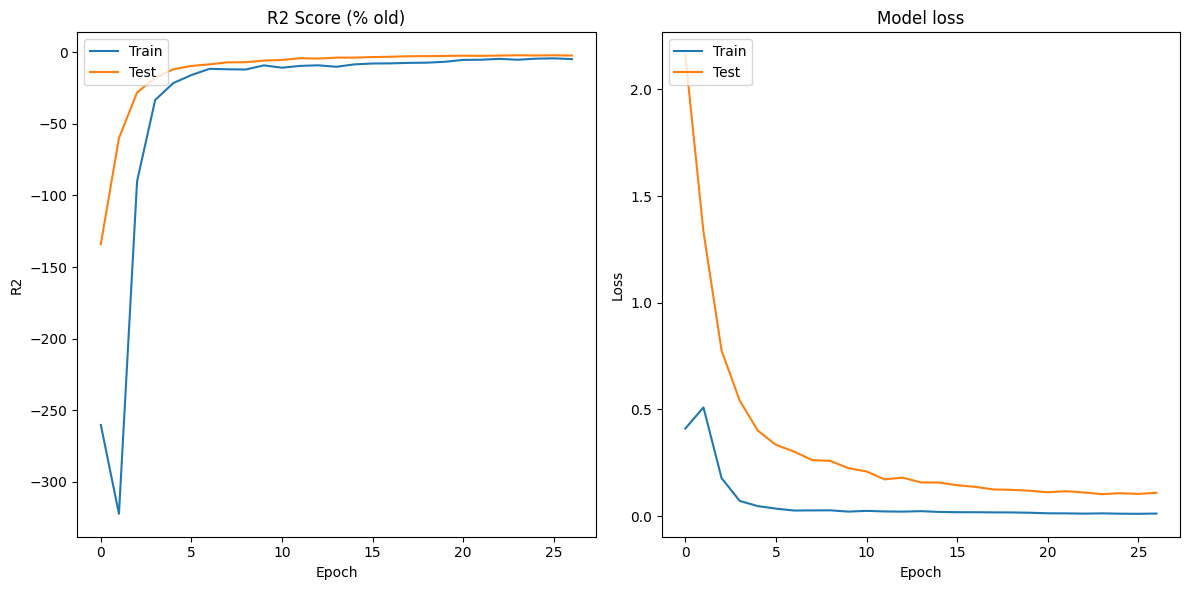

In [426]:
plot_history(history)

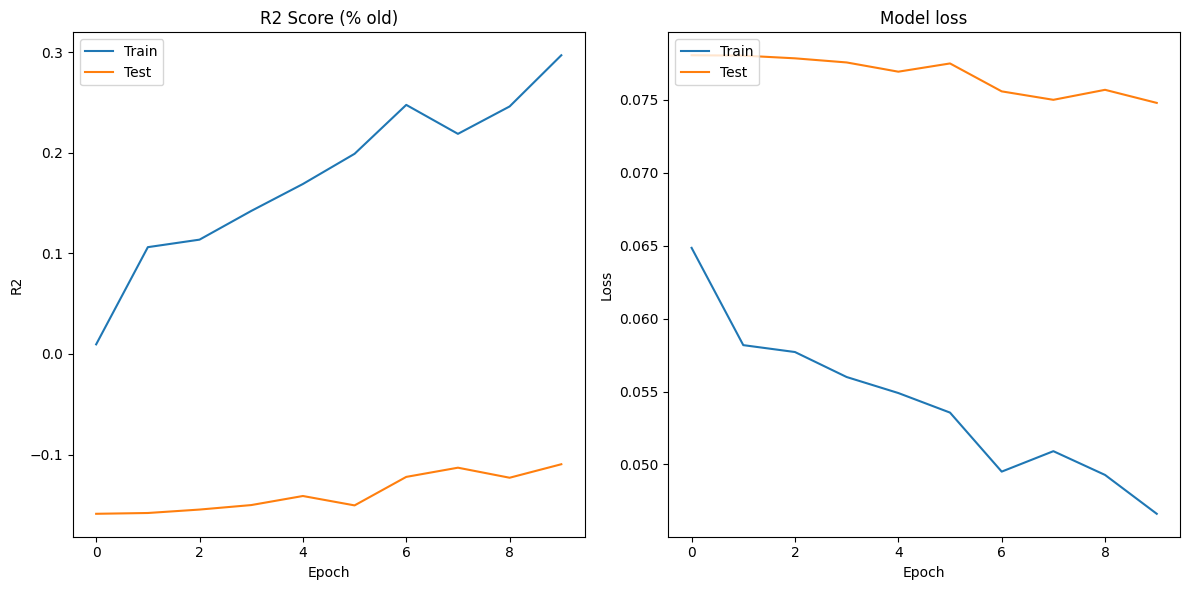

In [55]:
plot_history(history)